In [4]:
open_ia_deployments = [{"azure":False,"deployment":"gpt-4o-mini"},{"azure":False,"deployment":"gpt-4o-2024-08-06"}]
azure_deployments = [{"deployment":"gpt-4o", "api_version":"2024-02-15-preview"}, 
                     {"deployment":"gpt-4o-mini", "api_version":"2024-02-15-preview"},
                     {"deployment":"gpt-35-turbo", "api_version":"2023-03-15-preview"}]

In [45]:
import os
import pandas as pd
import wandb
from datetime import datetime
import time
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from src.open_ia_chat import OpenAIChatModel


In [16]:
load_dotenv()

True

# load model

In [17]:
open_ia_model = OpenAIChatModel(**open_ia_deployments[1])
azure_open_ia_model = OpenAIChatModel(**azure_deployments[1])
open_ia_model.model

'gpt-4o-2024-08-06'

In [5]:
open_ia_model.chat_model_client.invoke("suma 2 mas 2")

AIMessage(content='La suma de 2 más 2 es 4.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 14, 'total_tokens': 26, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_8080548e81', 'finish_reason': 'stop', 'logprobs': None}, id='run-f7d6cb50-5531-4225-88a0-353061d65116-0', usage_metadata={'input_tokens': 14, 'output_tokens': 12, 'total_tokens': 26})

# load dataset

In [18]:
splits = {'train': 'data/train-00000-of-00001-7b34565378f02992.parquet', 'val': 'data/val-00000-of-00001-d7338c59b5e5031f.parquet', 'test': 'data/test-00000-of-00001-c830a979da438bff.parquet'}
df_train = pd.read_parquet("hf://datasets/PrevenIA/spanish-suicide-intent/" + splits["train"])
#df_val = pd.read_parquet("hf://datasets/PrevenIA/spanish-suicide-intent/" + splits["val"])

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136136 entries, 0 to 136135
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Text               136136 non-null  object
 1   Label              136136 non-null  int64 
 2   dataset            136136 non-null  object
 3   __index_level_0__  136136 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


In [20]:
df_train.head()

,Text,Label,dataset,__index_level_0__
0,¿Por qué hacer que mejore? ¿Por qué la escuela...,1,Hackaton Somos NLP,5071
1,- Roma \n- Milán \n- Nápoles \n- Turín \n- Pal...,0,Hackaton Somos NLP,9391
2,¿Cuál es la noticia más importante en tu área ...,0,Hackaton Somos NLP,1752
3,Una semana de identificación izquierda más bie...,1,Hackaton Somos NLP,5363
4,Podría ser que no estudiaras de la manera corr...,0,Hackaton Somos NLP,107


In [46]:
df_label_1 = df_train[df_train['Label'] == 1]
df_label_0 = df_train[df_train['Label'] == 0]

# Toma 10,000 muestras aleatorias de cada grupo
sampled_label_1 = df_label_1.sample(n=10000, random_state=42)
sampled_label_0 = df_label_0.sample(n=10000, random_state=42)

sampled_df = pd.concat([sampled_label_1, sampled_label_0])

# Reordena las filas aleatoriamente
df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df.Label.value_counts()

Label
0    10000
1    10000
Name: count, dtype: int64

In [54]:
# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Calculate sizes
train_end = int(train_size * len(df))
eval_end = train_end + int(eval_size * len(df))

# Split the data
X_train = df[:train_end]
X_eval = df[train_end:eval_end]
X_test = df[eval_end:]

# zero shot prompting

In [67]:
today = datetime.today()
run_date = today.strftime("%d-%m-%Y_%H_%M")

wb_token = os.getenv("WANDB_TOKEN")
wandb.login(key=wb_token)
run = wandb.init(
    project='zero and few shot learning chatgpt on suicide intent-spanish',
    job_type="evaluation",
    name=f"zero_shot_gpt4_{run_date}",
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\felip\_netrc
wandb: Currently logged in as: felipeandres29 (felipeandres29-universidad-eafit). Use `wandb login --relogin` to force relogin


In [68]:
X_test['Text'].iloc[1]

'Creé un avatar reddit e hice que se pareciera a mí en la vida real.'

In [69]:
system_msg = """
Clasifica el siguiente post con "1" si identificas ideación o comportamiento suicida, y con "0" si no. Solo responde con "0" o "1" sin agregar ningún comentario adicional.
Post:""".strip()
zero_shot_prompt = ChatPromptTemplate.from_messages([("system", system_msg,),("human", "{text}"),])

In [70]:
llm = open_ia_model.chat_model_client
chain = zero_shot_prompt | llm

In [71]:
chain.invoke(  {
                "text": X_test['Text'].iloc[1],
            }
    
)

AIMessage(content='0', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 74, 'total_tokens': 75, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5050236cbd', 'finish_reason': 'stop', 'logprobs': None}, id='run-3a982c49-e13b-4480-8555-ef7cc530bea5-0', usage_metadata={'input_tokens': 74, 'output_tokens': 1, 'total_tokens': 75})

In [72]:
def generate_clasification(text):
    time.sleep(2) # temporizador para no sobrepasar los tokens por minuto
    try:
        response = chain.invoke(
            {
                "text": text,
            }
        )
        return response.content
    except Exception as e:
        print(e)
        return "-1"

In [73]:
df_test = X_test.copy()
# Aplicar la función a cada registro del DataFrame
df_test['gpt_classification_zero_shot'] = df_test['Text'].apply(generate_clasification)
df_test

,Text,Label,dataset,__index_level_0__,gpt_classification_zero_shot
18000,Estoy listo para morir.2 años de tiempo presta...,1,SuicideWatch,36253,1
18001,Creé un avatar reddit e hice que se pareciera ...,0,SuicideWatch,55987,0
18002,estos son los niños que luego en la vida están...,1,TwitterSuicidalAnalysis,10161,0
18003,"Estoy trabajando ahora, el primer día de mi nu...",1,SuicideWatch,93875,0
18004,Pensamientos matutinos Hubo un tiempo en el qu...,1,Ji et al. 2018,1764,1
...,...,...,...,...,...
19995,Mi escuela publicó esto a los estudiantes idk ...,0,SuicideWatch,44457,0
19996,Esto es un poco grande para mí porque he estad...,0,SuicideWatch,2270,0
19997,¿Estarías dispuesto a sacarme de la cornisa? M...,1,SuicideWatch,108633,1
19998,Me estoy ahogando lentamente por los números,1,TwitterSuicidalAnalysis,25724,1


In [74]:
df_test.to_csv('data/zero_shot_model_gpt4.csv', index=False)

In [136]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(
    df: pd.DataFrame,
    true_label_column: str = "Label",
    pred_label_column: str = "llm_label",
) -> None:
    """
    Function to plot confusion matrix
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true=df[true_label_column], y_pred= df[pred_label_column])
    print(f'Accuracy: {accuracy:.3f}')
    # Crear la matriz de confusión
    cm = confusion_matrix(df[true_label_column], df[pred_label_column], labels=[0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    report = classification_report(
            df[true_label_column], df[pred_label_column], labels=[0, 1]
        )
    # Imprimir el informe de clasificación
    print(report)

    return accuracy,report,cm

C:\Users\felip\AppData\Local\Temp\ipykernel_23592\3560325574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["gpt_classification_zero_shot"] = filtered_df["gpt_classification_zero_shot"].astype(int)


Accuracy: 0.730


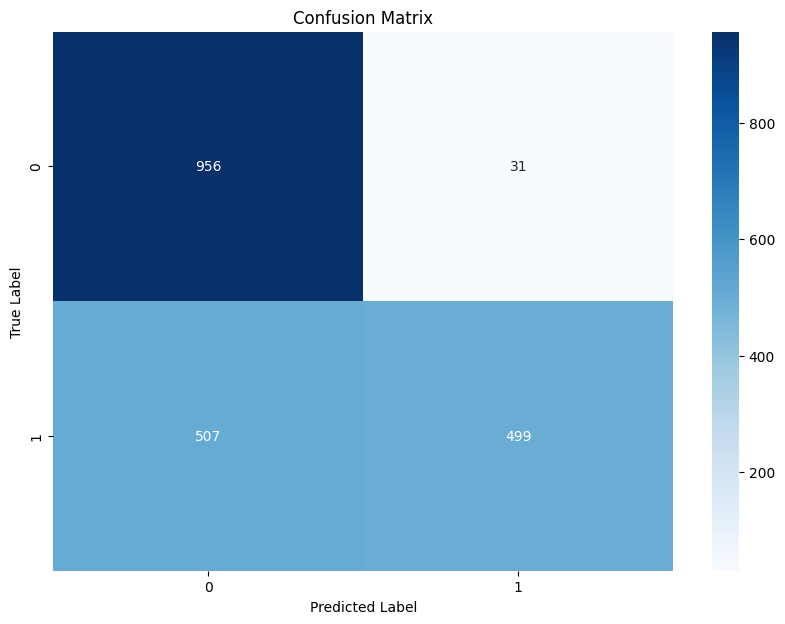

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       987
           1       0.94      0.50      0.65      1006

    accuracy                           0.73      1993
   macro avg       0.80      0.73      0.72      1993
weighted avg       0.80      0.73      0.71      1993



In [88]:
# Filtrar las filas donde las predicciones son 0 o 1
filtered_df = df_test[df_test["gpt_classification_zero_shot"].isin(["0", "1"])]

filtered_df["gpt_classification_zero_shot"] = filtered_df["gpt_classification_zero_shot"].astype(int)

accuracy,classification_report,cm =plot_confusion_matrix(filtered_df, 'Label', 'gpt_classification_zero_shot')

In [79]:
wandb.log({"Accuracy": accuracy})
wandb.log({"Matriz de confusion": cm})
wandb.log({"classification_report": classification_report})

In [92]:
labels =  [0, 1]
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Convertir las etiquetas verdaderas y predichas a índices
y_true_int = [label_to_index[label] for label in filtered_df["Label"]]
y_pred_int = [label_to_index[label] for label in filtered_df["gpt_classification_zero_shot"]]

# Registrar la matriz de confusión en wandb
wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None, 
        y_true=y_true_int, 
        preds=y_pred_int, 
        class_names=[str(label) for label in labels]
    )
})

In [93]:
wandb.finish()

Accuracy,▁
Accuracy,0.73006
classification_report,precis...


## create the samples for few shot prompting

In [121]:
def make_samples_from_df(df: pd.DataFrame, n_samples: int = 10) -> str:
    """
    function to generate samples
    """
    df_label_1 = df[df["Label"] == 1].sample(n_samples, random_state=42)
    df_label_0 = df[df["Label"] == 0].sample(n_samples, random_state=42)
    df_sampled = pd.concat([df_label_1, df_label_0])
    samples = ",\n".join(
        [
            f'"Post: {row["Text"]}" , clasificacion: {row["Label"]}'
            for _, row in df_sampled.iterrows()
        ]
    )
    return samples

In [122]:
samples = make_samples_from_df(X_train, n_samples = 10)
print(samples)

"Post: El mayor evento de networking estará aquí dentro de unos días. No querrás perderte esta rara oportunidad, regístrate gratis @, se iluminará..." , clasificacion: 1,
"Post: No tiene sentido. Me he convertido en todo lo que me dije que nunca sería. Arruino vidas. Mi única razón para vivir está enojada conmigo, y ella nunca va a volver. No tengo ninguna razón para vivir. No quiero tu ayuda. Sólo pensé que lo tiraría por ahí." , clasificacion: 1,
"Post: ¿Por qué sigo luchando?Estoy cansado, quiero morir, y sin embargo todavía estoy luchando para vivir. ¿Por qué? ¿Por qué es tan difícil para mí simplemente rendirme y rendirme. Nunca pedí esta vida sin embargo fue forzada sobre mí. Quiero volver a antes de que existiese. No quiero esto." , clasificacion: 1,
"Post: prometer más que cumplir es el mensaje que se envía ahora habrá que ver si eso sucederá, parece que las elecciones intermedias se definirán según los valores de cada partido y lo que el electorado decida que quiere ver en Est

In [123]:
system_msg = """
Basado en los siguientes ejemplos: {samples}, clasifica el post con "1" si identificas ideación o comportamiento suicida, y con "0" si no. Solo responde con "0" o "1" sin agregar comentarios adicionales.
Post:""".strip()
few_shot_prompt = ChatPromptTemplate.from_messages([("system", system_msg,),("human", "{text}"),])
SAMPLES = make_samples_from_df(df_train, n_samples = 10)

In [128]:
df_test['Label'].value_counts()

Label
1    1006
0     994
Name: count, dtype: int64

## Apply clasification function to sampled dataset

In [127]:
chain = few_shot_prompt | llm
def generate_clasification(text):
    time.sleep(1) # temporizador para no sobrepasar los tokens por minuto
    try:
        response = chain.invoke(
            {
                "samples": SAMPLES,
                "text": text,
            }
        )
        return response.content
    except Exception as e:
        print(e)
        return "-1"

In [129]:
today = datetime.today()
run_date = today.strftime("%d-%m-%Y_%H_%M")

wb_token = os.getenv("WANDB_TOKEN")

wandb.login(key=wb_token)
run = wandb.init(
    project='zero and few shot chatgpt on suicide intent-spanish',
    job_type="evaluation",
    name=f"few_shot_llama_{run_date}",
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\felip\_netrc


## tracking experiment with wandb

In [130]:
# Aplicar la función a cada registro del DataFrame
df_test['gpt_classification_few_shot'] = df_test['Text'].apply(generate_clasification)
df_test

,Text,Label,dataset,__index_level_0__,gpt_classification_zero_shot,gpt_classification_few_shot
18000,Estoy listo para morir.2 años de tiempo presta...,1,SuicideWatch,36253,1,1
18001,Creé un avatar reddit e hice que se pareciera ...,0,SuicideWatch,55987,0,0
18002,estos son los niños que luego en la vida están...,1,TwitterSuicidalAnalysis,10161,0,0
18003,"Estoy trabajando ahora, el primer día de mi nu...",1,SuicideWatch,93875,0,0
18004,Pensamientos matutinos Hubo un tiempo en el qu...,1,Ji et al. 2018,1764,1,1
...,...,...,...,...,...,...
19995,Mi escuela publicó esto a los estudiantes idk ...,0,SuicideWatch,44457,0,0
19996,Esto es un poco grande para mí porque he estad...,0,SuicideWatch,2270,0,0
19997,¿Estarías dispuesto a sacarme de la cornisa? M...,1,SuicideWatch,108633,1,1
19998,Me estoy ahogando lentamente por los números,1,TwitterSuicidalAnalysis,25724,1,1


In [131]:
df_test.to_csv('data/zero_shot_model_gpt4_2.csv', index=False)

# Testing model

In [134]:
# Filtrar las filas donde las predicciones son 0 o 1
filtered_df = df_test[df_test["gpt_classification_few_shot"].isin(["0", "1"])]

filtered_df["gpt_classification_few_shot"] = filtered_df["gpt_classification_few_shot"].astype(int)

C:\Users\felip\AppData\Local\Temp\ipykernel_23592\55335300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["gpt_classification_few_shot"] = filtered_df["gpt_classification_few_shot"].astype(int)


Accuracy: 0.765


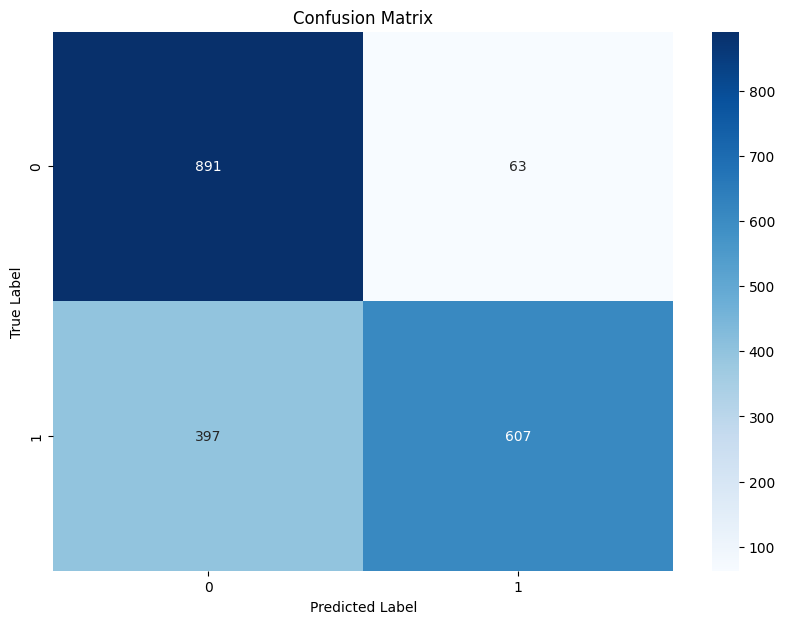

              precision    recall  f1-score   support

           0       0.69      0.93      0.79       954
           1       0.91      0.60      0.73      1004

    accuracy                           0.77      1958
   macro avg       0.80      0.77      0.76      1958
weighted avg       0.80      0.77      0.76      1958



In [137]:
accuracy,classification_report,cm =plot_confusion_matrix(filtered_df, 'Label', 'gpt_classification_few_shot')

In [138]:
wandb.log({"Accuracy": accuracy})
wandb.log({"Matriz de confusion": cm})
wandb.log({"classification_report": classification_report})

In [139]:
labels =  [0, 1]
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Convertir las etiquetas verdaderas y predichas a índices
y_true_int = [label_to_index[label] for label in filtered_df["Label"]]
y_pred_int = [label_to_index[label] for label in filtered_df["gpt_classification_few_shot"]]

# Registrar la matriz de confusión en wandb
wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None, 
        y_true=y_true_int, 
        preds=y_pred_int, 
        class_names=[str(label) for label in labels]
    )
})

In [140]:
wandb.finish()

Accuracy,▁
Accuracy,0.76507
classification_report,precis...
